# 实验大作业




导入库文件

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import comtheory as ct
from scipy.io import wavfile
import pygame
import os
import scipy .signal as signal

# 请助教老师注意，为了代码的整洁性，我编写了新的库函数
import helperfunc as hf

import comtheory as ct

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


1. 信源

In [5]:
#导入音频
import_audio_rate, import_audio_data = wavfile.read('天雷滚滚.wav')
audio_data1 = import_audio_data[import_audio_rate:6*import_audio_rate,0]
audio_data2 = import_audio_data[import_audio_rate:6*import_audio_rate,1]


#导入数据
if not os.path.exists('bitstream.bin'):  # 检查文件是否存在
    print("文件不存在，请先生成比特序列并保存到本地文件")
else:  # 从本地文件读取比特流  
    with open('bitstream.bin', 'rb') as f:
        imported_bitstream = f.read()
bit_data = []
for byte in imported_bitstream:
    binary_str = bin(byte)[2:].zfill(8)   #将每个字节转换为二进制字符串，然后去掉前缀 '0b'，并填充到8位
    bit_data.extend([int(bit) for bit in binary_str])    #将二进制字符串转换为列表，并将字符转换为整数

#定义时间轴t和频率轴f
Fs = import_audio_rate
dt = 1/Fs
T_obs = len(audio_data1)*dt  #5s
t=np.arange(0,T_obs,dt)
N_obs = len(t)
df =1/T_obs
f=np.arange(-N_obs/2*df,N_obs/2*df,df)

#需要传输的原始音频数据：audio_data1，audio_data2
#需要传输的比特数据：bit_data

2. 发送端

2.1 信道编码

In [8]:
bit_audio_data1 = hf.int16_to_bit_list_fast(audio_data1)
bit_audio_data2 = hf.int16_to_bit_list_fast(audio_data2)

# 卷积编码
#定义生成矩阵
G = np.array([[1, 1, 1], [1, 0, 1]]) 
encoded_audio_data1 = hf.conv_encode(bit_audio_data1, G)
encoded_audio_data2 = hf.conv_encode(bit_audio_data2, G)
encoded_bit_data = hf.conv_encode(bit_data, G)

# 交织
# 定义交织器参数
# 交织深度 (行数) 和交织宽度 (列数)
interleaver_depth = 120
interleaver_width = 120

# 对三组位流进行交织
interleaved_audio_data1 = hf.interleave(encoded_audio_data1, interleaver_depth, interleaver_width)
interleaved_audio_data2 = hf.interleave(encoded_audio_data2, interleaver_depth, interleaver_width)
interleaved_bit_data = hf.interleave(encoded_bit_data, interleaver_depth, interleaver_width)


2.2 调制（64QAM）

In [10]:
# 星座映射
I_levels_qam_audio_data1, Q_levels_qam_audio_data1 = hf.qam64_mapper(interleaved_audio_data1)
I_levels_qam_audio_data2, Q_levels_qam_audio_data2 = hf.qam64_mapper(interleaved_audio_data2)
I_levels_qam_bit_data, Q_levels_qam_bit_data = hf.qam64_mapper(interleaved_bit_data)

# RCC根升余弦成形滤波
## 选择参数
### 这个Fs与之前定义的不同，是过采样
Fs_system = 2.272 * 10**6  # 2.272 MHz
Rs_audio_stream = 284 * 10**3  # 284 kbaud
Rs_bitdata_stream = 32 * 10**3  # 32 kbaud
rcc_alpha = 0.25

# 成形滤波
shaped_I_audio1 = hf.raised_cosine_filter(I_levels_qam_audio_data1, Rs_audio_stream, Fs_system, rcc_alpha)
shaped_Q_audio1 = hf.raised_cosine_filter(Q_levels_qam_audio_data1, Rs_audio_stream, Fs_system, rcc_alpha)

shaped_I_audio2 = hf.raised_cosine_filter(I_levels_qam_audio_data2, Rs_audio_stream, Fs_system, rcc_alpha)
shaped_Q_audio2 = hf.raised_cosine_filter(Q_levels_qam_audio_data2, Rs_audio_stream, Fs_system, rcc_alpha)

shaped_I_bitdata = hf.raised_cosine_filter(I_levels_qam_bit_data, Rs_bitdata_stream, Fs_system, rcc_alpha)
shaped_Q_bitdata = hf.raised_cosine_filter(Q_levels_qam_bit_data, Rs_bitdata_stream, Fs_system, rcc_alpha)

# 载波调制

## 第一路音频信号的载波频率 (201 kHz)
fc_audio1 = 201 * 10**3 # Hz
## 第二路音频信号的载波频率 (601.5 kHz)
fc_audio2 = 602 * 10**3 # Hz
## 比特数据信号的载波频率 (835 kHz)
fc_bitdata = 840 * 10**3 # Hz

modulated_audio_signal1 = hf.qam_modulate(shaped_I_audio1, shaped_Q_audio1, fc_audio1, Fs_system)
modulated_audio_signal2 = hf.qam_modulate(shaped_I_audio2, shaped_Q_audio2, fc_audio2, Fs_system)
modulated_bit_signal = hf.qam_modulate(shaped_I_bitdata, shaped_Q_bitdata, fc_bitdata, Fs_system)


# 统一信号长度并进行频分复用 (FDM)

## 找到所有调制信号中的最大长度
max_len = max(len(modulated_audio_signal1), len(modulated_audio_signal2), len(modulated_bit_signal))

## 对所有信号进行零填充，使其达到最大长度
padded_audio_signal1 = np.pad(modulated_audio_signal1, (0, max_len - len(modulated_audio_signal1)), 'constant')
padded_audio_signal2 = np.pad(modulated_audio_signal2, (0, max_len - len(modulated_audio_signal2)), 'constant')
padded_bit_signal = np.pad(modulated_bit_signal, (0, max_len - len(modulated_bit_signal)), 'constant')

fdm_signal = padded_audio_signal1 + padded_audio_signal2 + padded_bit_signal

In [ ]:
Fs = Fs_system # 关键修改：将采样率更新为系统采样率
dt = 1/Fs_system
T_obs = max_len * dt 
t = np.arange(0, T_obs, dt)
N_obs = len(t)
df = 1/T_obs
f = np.arange(-N_obs/2*df, N_obs/2*df, df)

In [11]:
#-----发送到信道上的已调信号统一命名为s_t
s_t = np.zeros(len(t)) #这里装已调信号
ff,S_f = ct.FourierTransfrom(t,s_t)

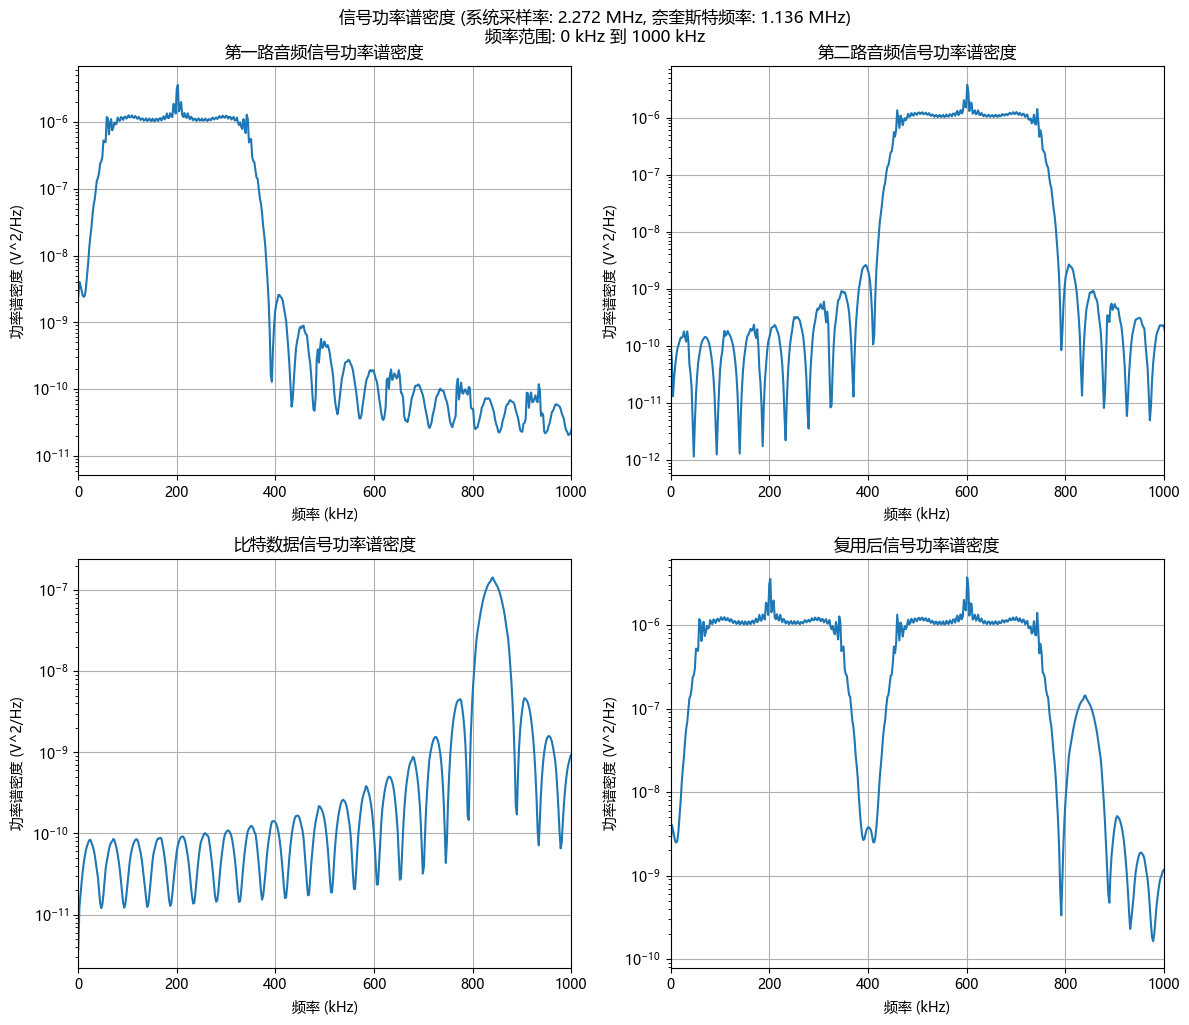

In [12]:
plt.figure(figsize=(12, 10)) # 设置图的大小

# 定义一个辅助函数来绘制PSD，减少重复代码
def plot_psd(ax, signal_data, title_text, fs_rate, xlim_min_kHz=0, xlim_max_kHz=1000):
    """
    计算并绘制信号的功率谱密度。
    ax: matplotlib axes 对象
    signal_data: 输入信号数据
    title_text: 图的标题
    fs_rate: 信号的采样率
    xlim_min_kHz: X轴的最小频率（kHz）
    xlim_max_kHz: X轴的最大频率（kHz）
    """
    frequencies, psd = signal.welch(signal_data, fs=fs_rate, nperseg=1024, scaling='density')
    # 绘制 PSD，Y轴使用对数刻度，X轴频率转换为 kHz    ax.semilogy(frequencies / 1000, psd) 
    
    ax.set_title(title_text)
    ax.set_xlabel('频率 (kHz)')
    ax.set_ylabel('功率谱密度 (V^2/Hz)')
    ax.grid(True)
    
    # 限制X轴范围
    # 注意：welch 输出的是单边谱，所以 X轴的最小值不能是负数
    ax.set_xlim(xlim_min_kHz, xlim_max_kHz) 

# -------------------- 绘制各个信号的PSD --------------------
ax1 = plt.subplot(2, 2, 1) # 2x2 网格的第一个子图
plot_psd(ax1, modulated_audio_signal1, '第一路音频信号功率谱密度', Fs_system, xlim_min_kHz=0, xlim_max_kHz=1000)

ax2 = plt.subplot(2, 2, 2) # 2x2 网格的第二个子图
plot_psd(ax2, modulated_audio_signal2, '第二路音频信号功率谱密度', Fs_system, xlim_min_kHz=0, xlim_max_kHz=1000)

ax3 = plt.subplot(2, 2, 3) # 2x2 网格的第三个子图
plot_psd(ax3, modulated_bit_signal, '比特数据信号功率谱密度', Fs_system, xlim_min_kHz=0, xlim_max_kHz=1000)

ax4 = plt.subplot(2, 2, 4) # 2x2 网格的第四个子图
plot_psd(ax4, fdm_signal, '复用后信号功率谱密度', Fs_system, xlim_min_kHz=0, xlim_max_kHz=1000)

# -------------------- 图表整体设置 --------------------
plt.tight_layout() # 自动调整子图布局，避免重叠


3. 信道

In [14]:
#理想限带信道的冲激响应h_channel_t和传递函数H_channel_f
BPF_low_freq = 900
BPF_high_freq = 1100
H_channel_f = 0.01*np.where((np.abs(f) >= BPF_low_freq) & (np.abs(f) <= BPF_high_freq), 1, 0)
tt,h_channel_t = ct.RFourierTransfrom(f,H_channel_f)

#宽带高斯噪声
N0 = 1e-10 #噪声单边功率谱密度
sigma = np.sqrt(N0*Fs)
nw_t = np.random.normal(loc=0, scale=sigma, size=len(t))

#信号s(t)通过信道
Y_f = S_f*H_channel_f
tt,y_t = ct.RFourierTransfrom(f,Y_f)
y_t = y_t+nw_t

4. 接收端

In [16]:
#-------接收端各模块实现（接收信号是y_t）

5. 信宿